# LLM Code Comparison Benchmark (eval the eval)

Measures how often the LLM correctly predicts whether a PR will resolve an issue, should be useful for prompt optimization and seeing how accurate LLM code comparison is relative to running tests.

Compares SWEBench-submitted patches to ground truth patches, and sees if the LLM can guess whether the submitted patch would resolve the issue.

### Envars:
- `OPENAI_API_KEY` for LLM calls

In [3]:
%pip install -q datasets openai datasets pandas matplotlib
!git clone https://github.com/swe-bench/experiments.git

Cloning into 'experiments'...
remote: Enumerating objects: 2911, done.
remote: Counting objects: 100% (1667/1667), done.
remote: Compressing objects: 100% (1094/1094), done.
remote: Total 2911 (delta 631), reused 740 (delta 572), pack-reused 1244 (from 1)
Receiving objects: 100% (2911/2911), 64.70 MiB | 16.28 MiB/s, done.
Resolving deltas: 100% (1046/1046), done.
Updating files: 100% (2172/2172), done.


In [5]:
from pathlib import Path
import json
import random
from datasets import load_dataset


eval_dir = Path("experiments/evaluation/lite")
ds = load_dataset("princeton-nlp/SWE-bench_Lite")

/Users/alex/workspace/trading-projects/bittensor-projects/taoception/taoception-venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from dataclasses import dataclass
from typing import *
import datasets


@dataclass
class IssueSubmission:
    instance_id: str
    problem_statement: str
    model_patch: str
    gold_patch: str
    resolved_state: str
    submission_dir: str

datasets.logging.set_verbosity(datasets.logging.CRITICAL)

instance_to_state = {}

def get_instances(max_items: Optional[int] = None, random_shuffle: bool = True) -> List[IssueSubmission]:
    instances = []

    all_dirs = list(eval_dir.iterdir())
    if random_shuffle:
        random.shuffle(all_dirs)

    for current_dir in all_dirs:
        print(f"Using SWEBench submission at {current_dir}")

        print("Loading results.json...")
        with open(current_dir / "results/results.json", "r") as file:
            swebench_results = json.load(file)
        print("Finished loading results.json")
    
        # Amend reverse map
        for state, instance_ids in swebench_results.items():
            for iid in instance_ids:
                instance_to_state[iid] = state

        print("Loading submitted preds...")
        with open(current_dir / "all_preds.jsonl", "r") as file:
            submitted_preds = [json.loads(line) for line in file]
        print(f"Loadeded submitted preds, length={len(submitted_preds)}")

        for submitted_pred in submitted_preds:
            instance_id, model_patch = submitted_pred["instance_id"], submitted_pred["model_patch"]
            resolved_state = instance_to_state[instance_id]

            issue_row = ds["test"].filter(lambda row: row["instance_id"] == instance_id)[0]
            gold_patch, problem_statement = issue_row["patch"], issue_row["problem_statement"]

            # print("Adding instance of id ", instance_id)
            instances.append(IssueSubmission(instance_id, problem_statement, model_patch, gold_patch, resolved_state, current_dir))

            if max_items is not None and len(instances) > max_items:
                print(f"Reached limit of {max_items} instances. Returning...")
                return instances
        print(f"Reached end of current dir {current_dir}. Instances: {len(instances)}")

    return instances

In [81]:
from collections import Counter
from openai import OpenAI

client = OpenAI()

def run_llm_eval(llm_prompt_template: str, issue_submission: IssueSubmission) -> Tuple[str, str]:
    prompt = llm_prompt_template.format(
        model_patch=issue_submission.model_patch,
        gold_patch=issue_submission.gold_patch,
        problem_statement=issue_submission.problem_statement
    )
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
    )
    model_output = response.choices[0].message.content
    return model_output


def eval_prompt(
    llm_prompt_template: str,
    parse_llm_output: Callable,
    num_issues: int = 10,
    should_log: bool =True
) -> List[Tuple[Optional[int], str]]:
    # Gather data
    instances = get_instances(max_items=num_issues, random_shuffle=False)
    
    # Eval data
    output_scores = {}
    full_responses = {}
    for instance in instances:
        try:
            model_text = run_llm_eval(llm_prompt_template, instance)

            try:
                output_scores[instance.instance_id] = parse_llm_output(model_text)
                if should_log:
                    print(f"Issue {instance.instance_id} with state {instance.resolved_state}, model score={output_scores[instance.instance_id]}")
            except ValueError as e:
                print(f"Issue '{instance.instance_id}': model output ended with '{model_text[-1]}' instead of 0 or 1. Error: {e}")

            full_responses[instance.instance_id] = model_text
        except Exception as e:
            print(f"Ran into error: {e}")
            continue

    return output_scores, full_responses


In [109]:
BINARY_TEMPLATE_1 = """
You are being asked to identify important differences between 2 solutions to a given problem. The problem is as follows:
```
{problem_statement}
```
The 1st solution is:
```
{model_patch}
```
The second solution is:
```
{gold_patch}
```
First, list all the differences between these patches of code that you can think of. 
Then, let's assume that the second patch is a correct solution to the problem. 
Based on the similarity to this patch and the differences you outlined, would you expect the first patch to also be a correct solution? 
Reason about why or why not. 
Then, output a 1 if you think the first patch will address the problem, and a 0 if you think it will not. 
Do not use markdown, and make sure the digit is the last thing you output.
"""


print("Running eval for prompt #1...")
binary_classifier_outputs, _ = eval_prompt(
    BINARY_TEMPLATE_1,
    lambda response: int(response[-1]),
    num_issues=2,
    should_log=True,
)

# Print summary
score_outputs = [(instance_id, score) for instance_id, score in binary_classifier_outputs.items()]
zeros = Counter(instance_to_state[instance_id] for instance_id, score in score_outputs if score == 0)
ones = Counter(instance_to_state[instance_id] for instance_id, score in score_outputs if score == 1)

print("\nEval results:")
print("    zeros: ", zeros)
print("    ones: ", ones)

Running eval for prompt #1...
Using SWEBench submission at experiments/evaluation/lite/20240612_MASAI_gpt4o
Loading results.json...
Finished loading results.json
Loading submitted preds...
Loadeded submitted preds, length=287
Reached limit of 2 instances. Returning...
Issue matplotlib__matplotlib-25311 with state applied, model score=0
Issue django__django-11179 with state resolved, model score=1
Issue sympy__sympy-22840 with state applied, model score=1

Eval results:
    zeros:  Counter({'applied': 1})
    ones:  Counter({'resolved': 1, 'applied': 1})


In [112]:
SCORER_TEMPLATE_1 = """
You are being asked to identify important differences between 2 solutions to a given problem. The problem is as follows:
```
{problem_statement}
```
The 1st solution is:
```
{model_patch}
```
The second solution is:
```
{gold_patch}
```
First, list all the differences between these patches of code that you can think of. 
Then, let's assume that the second patch is a correct solution to the problem. 
Based on the similarity to this patch and the differences you outlined, would you expect the first patch to also be a correct solution? 
Reason about why or why not. 
Output a number out of 100 ranking how similar these 2 patches are. Explain why or why not. The number should be padded to have a length of 3, meaning write "0" as "000", "1" as "001", and 99 as "099".
Do not use markdown, and make sure the digit is the last thing you output.
"""

import pandas as pd

scorer_outputs, _ = eval_prompt(
    SCORER_TEMPLATE_1,
    lambda response: float(response[-3:]),
    num_issues=300,
    should_log=True,
)
df = pd.DataFrame(
    [(instance_id, score, instance_to_state[instance_id]) for instance_id, score in scorer_outputs.items()],
    columns=["Instance ID", "Score", "State"]
)
df

Using SWEBench submission at experiments/evaluation/lite/20240612_MASAI_gpt4o
Loading results.json...
Finished loading results.json
Loading submitted preds...
Loadeded submitted preds, length=287
Reached end of current dir experiments/evaluation/lite/20240612_MASAI_gpt4o. Instances: 287
Using SWEBench submission at experiments/evaluation/lite/20240721_amazon-q-developer-agent-20240719-dev
Loading results.json...
Finished loading results.json
Loading submitted preds...
Loadeded submitted preds, length=300
Reached limit of 300 instances. Returning...
Issue matplotlib__matplotlib-25311 with state applied, model score=60.0
Issue django__django-11179 with state resolved, model score=95.0
Issue sympy__sympy-22840 with state applied, model score=75.0
Issue 'django__django-11964': model output ended with '.' instead of 0 or 1. Error: could not convert string to float: 'on.'
Issue django__django-12453 with state resolved, model score=80.0
Issue django__django-13315 with state applied, model sco

,Instance ID,Score,State
0,matplotlib__matplotlib-25311,60.0,applied
1,django__django-11179,95.0,resolved
2,sympy__sympy-22840,75.0,applied
3,django__django-12453,80.0,resolved
4,django__django-13315,45.0,resolved
...,...,...,...
215,django__django-12284,10.0,applied
216,pytest-dev__pytest-11143,50.0,resolved
217,scikit-learn__scikit-learn-25747,60.0,applied
218,django__django-11283,65.0,applied


Average scores by issue state:
State
applied          50.842105
no_generation    45.000000
resolved         69.432836
Name: Score, dtype: float64


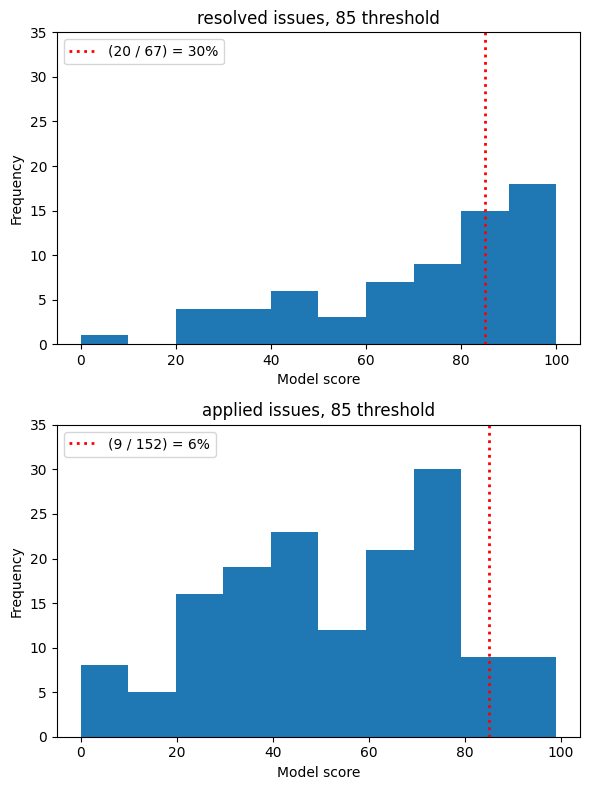

In [208]:
grouped_df = df.groupby("State")["Score"]
print("Average scores by issue state:")
print(grouped_df.mean())

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(6, 8))
threshold = 85
for ax, state in zip(axes, ["resolved", "applied"]):
    data = df[df["State"] == state][["Score"]].sort_values(by="Score", ascending=True)

    a, b = len(data[data["Score"] > threshold]), len(data)
    ax.axvline(threshold, color='red', linestyle=':', linewidth=2, label=f"({a} / {b}) = {a / b * 100:.0f}%")
    ax.set_title(f"{state} issues, {threshold} threshold")
    ax.set_ylim(0, 35)
    
    ax.set_xlabel("Model score")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.hist(data)

plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
plt.show()

Using a threshold of 85, we have:
- **false positives**: $9/29=31\%$
- **false negatives**: $47/190=25\%$

In [ ]:
resolved = df[df["State"] == "resolved"].sort_values(by="Score", ascending=True)
applied = df[df["State"] == "applied"][["Score"]].sort_values(by="Score", ascending=True)
print(f"The false positive rate is 9/29 = 31%")
print(f"The false negative rate is ")